# Convolution Network Introduction

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

## Some helper functions

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    data = pickle.load(fo, encoding='latin1')
    fo.close
    return data


def clean(data):
    # We need to fix shape
    imgs = data.reshape(data.shape[0], 3, 32, 32).astype(np.float32)
    # Naive grayscala conversion
    grayscala_imgs = imgs.mean(1)
    # For faster processing we only need 24x24 images
    cropped_imgs = grayscala_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized
    
    
def load_images(path):
    names = unpickle(path + 'batches.meta')['label_names']
    data, labels = [], []
    for i in range(1, 6):
        filename = path + 'data_batch_' + str(i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack([data, batch_data['data']])
            labels = np.hstack([labels, batch_data['labels']])
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    data = clean(data)
    return names, data, labels

## Load and show some images

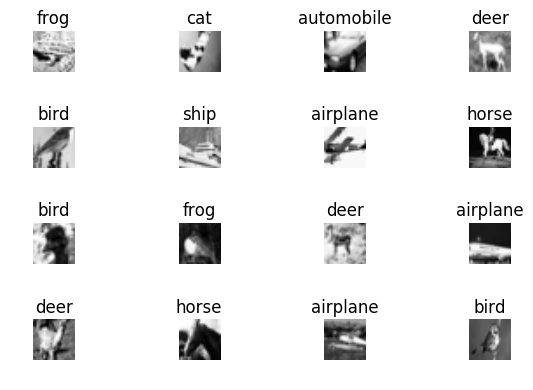

In [3]:
names, data, labels = load_images('../datasets/cifar-10-batches-py/')

plt.figure()
rows, cols = 4, 4
random_idxs = random.sample(range(len(data)), rows * cols)
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    j = random_idxs[i]
    plt.title(names[labels[j]])
    img = np.reshape(data[j, :], (24, 24))
    plt.imshow(img, cmap='Greys_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Generate filters

In [4]:
W = tf.Variable(tf.random_normal([5, 5, 1, 32]))

def show_filters(filters):
    plt.figure()
    rows, cols = 4, 8
    for i in range(rows * cols):
        img = filters[:, :, 0, i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    plt.show()
    
    
def show_conv_filters(filters):
    plt.figure()
    rows, cols = 4, 8
    for i in range(rows * cols):
        img = filters[0, :, :, i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    plt.show()    

Lets visualize randomly initialized filters

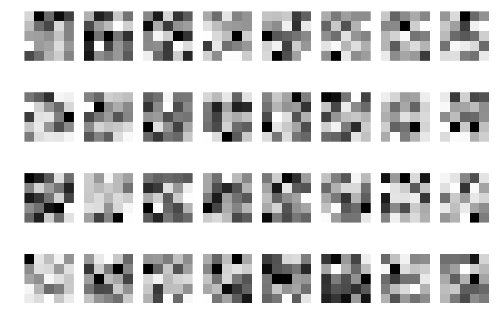

In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    W_val = sess.run(W)
    show_filters(W_val)

## Visualizing Convolution

Plot single image which will be used to check convolution filters

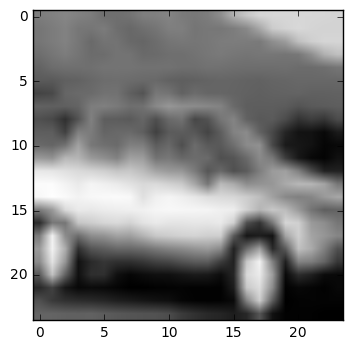

In [8]:
raw_data = data[4, :]
raw_img = np.reshape(raw_data, (24, 24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
plt.show()

How the convolution filters change image.
Those are still random filters

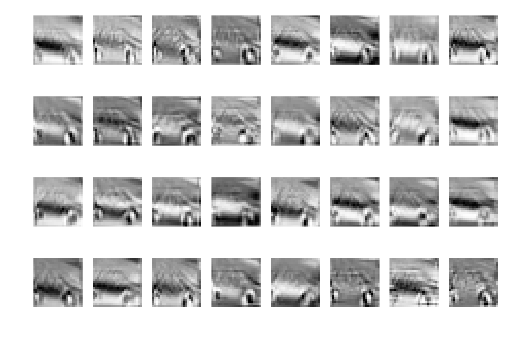

(1, 24, 24, 32)


In [17]:
x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])
b = tf.Variable(tf.random_normal([32]))
conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_val = sess.run(conv)
    show_conv_filters(conv_val)
    print(np.shape(conv_val))

And now add nonlinearity

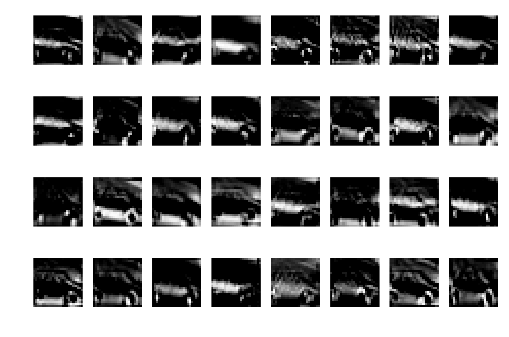

(1, 24, 24, 32)


In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_out_val = sess.run(conv_out)
    show_conv_filters(conv_out_val)
    print(np.shape(conv_out_val))

## Max-pooling

Now we have 32 filters. We will for every pixel in the image select max pixel from all the filters.

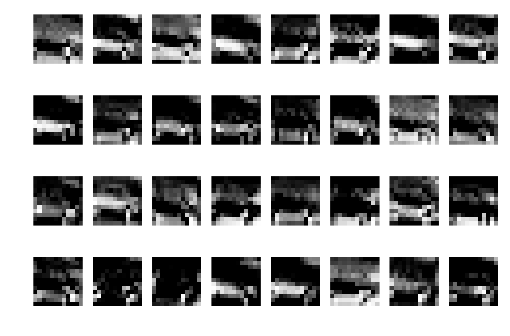

(1, 12, 12, 32)


In [20]:
k = 2
maxpool = tf.nn.max_pool(conv_out, 
                         ksize=[1, k, k, 1],
                         strides=[1, k, k, 1],
                         padding='SAME')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    maxpool_val = sess.run(maxpool)
    show_conv_filters(maxpool_val)
    print(np.shape(maxpool_val))

## Add training